In [178]:
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
import warnings
import logging
warnings.filterwarnings("ignore", module="vrpy\..*")

sns.set()
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
instance = loadInstance(2)

In [140]:
instance.Products

[    1    11]

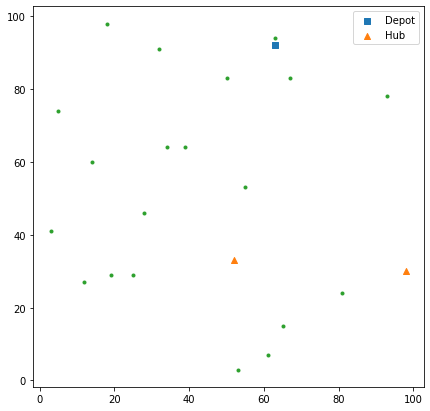

In [141]:
plotInstance(instance)

In [142]:
def locIDtoHubID(loc_ID):
    return loc_ID - 1

def hubIDtoLocID(hub_ID):
    return hub_ID + 1

In [143]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist =  math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist

In [144]:
def requestClosestHub(instance: InstanceCO22, request: InstanceCO22.Request) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if request.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(instance.Locations[request.customerLocID-1],hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID

In [145]:
def requestsClosestHub(instance: InstanceCO22) -> dict:
    #return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for req in instance.Requests:
        res[req.ID] = requestClosestHub(instance, req)
    return res

In [146]:
def requestsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerRequest = requestsClosestHub(instance= instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for reqID, closestHubLocID in closestHubPerRequest.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(reqID)
    return res

In [147]:
def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [148]:
def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res

In [149]:
def addAllEdges(G: nx.DiGraph, checkWindowOverlap: bool = False) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                if checkWindowOverlap and locID1 not in ["Source","Sink"] and locID2 not in ["Source", "Sink"] and not windowOverlap(node1['periodIDs'], node2['periodIDs']):
                        continue
                dist = math.ceil( math.sqrt( pow(node1['X']-node2['X'],2) + pow(node1['Y']-node2['Y'],2) ))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time = dist, cost=dist)   
    return G        

In [150]:
def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID = reqLoc.ID, reqID = req.ID, X=reqLoc.X, Y=reqLoc.Y, demand = sum(req.amounts), amounts = req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink",locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G

In [151]:
def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    #create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    #print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res

In [152]:
def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    #add hubs
    for (day, hubLocID), hubData in dayRoutes.items():
        G.add_node(f"{hubLocID}.1", locID = hubLocID, demand = 0, amounts= 0, X=instance.Locations[hubLocID-1].X, Y=instance.Locations[hubLocID-1].Y)

    for (day, hubLocID), hubData in dayRoutes.items():
        i = 1
        nodeID = f"{hubLocID}.{i}"
        while nodeID in G.nodes and G.nodes[nodeID]['demand'] + hubData['demand'] > instance.TruckCapacity: 
            i+=1
            nodeID = f"{hubLocID}.{i}"
        if nodeID not in G.nodes:
            G.add_node(nodeID, locID = hubLocID, demand = 0, amounts= 0, X=instance.Locations[hubLocID-1].X, Y=instance.Locations[hubLocID-1].Y)

        G.nodes[nodeID]['amounts'] = list(np.array(G.nodes[nodeID]['amounts']) + np.array(hubData['amounts']))
        G.nodes[nodeID]['demand'] = G.nodes[nodeID]['demand']+hubData['demand']

    G.add_node("Source", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)
    G.add_node("Sink", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)

    G = addAllEdges(G)
    return G

In [153]:
def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    #for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    print(best_routes)
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {key: [G_dict[id] for id in best_routes[key]] for key in best_routes.keys()}
    print(res)
    return res

In [154]:
def solveHub(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    return hubRoutes

In [155]:
def extractDays(hubRoutes, days: list) -> dict:
    res = {}
    for day, dayRoutes in hubRoutes.items():
        if day in days:
            for hubLocID in dayRoutes:
                newID = (day, hubLocID)
                res[newID] = dayRoutes[hubLocID]
    return res

In [156]:
#%%capture
#dayRoutes = solveHub(instance)
#dayRoutes = extractDays(dayRoutes, [1,2,3,4])
#print(dayRoutes)
#G = createNxDepot(instance,dayRoutes)

In [157]:
#G.nodes(data=True)

In [158]:
#pos = {id: (val['X'],val['Y']) for id,val in G.nodes(data=True)}
#nx.draw(G,pos=pos, with_labels=True)

In [159]:
#prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
#prob.duration = instance.TruckMaxDistance
#prob.fixed_cost = instance.TruckDayCost
#prob.solve()

In [160]:
#prob.best_routes

In [161]:
#nx.draw(prob._best_routes_as_graphs[0], pos=pos, with_labels=True)
#sns.set()
#nx.draw_networkx(prob._best_routes_as_graphs[0], pos = pos, with_labels=True)

In [162]:
class timeWindowGenerator(object):
    def __init__(self, day_length=1000, padding=200, n=20):
        res = []
        for i in range(0,n):
            begin = day_length*i + padding*i
            window = [begin, begin+day_length ]
            res.append(window)
        self.windows = res

    def getWindow(self, d1, d2):
        return [self.windows[d1-1][0], self.windows[d2-1][1]], list(range(d1,d2+1))

In [163]:
def windowOverlap(w1, w2):
    return bool(set(w1) & set(w2))

In [164]:
def giantDepotNx(hubRoute: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    twg = timeWindowGenerator(1,0,20)
    daysFresh = [_.daysFresh for _ in instance.Products]
    productIDs = list(range(1, len(instance.Products)+1))
    for day, dayRoute in hubRoute.items():  # for every day
        for hubLocID, hubData in dayRoute.items():  # for every hub
            for productID in productIDs:
                productDemand = hubData['amounts'][productID-1]
                if productDemand > 0:
                    d1 = max(day - daysFresh[productID-1]+1, 1)
                    window, periodIDs = twg.getWindow(d1=d1, d2=day)
                    upper = window[1]
                    lower = window[0]
                    nodeID = f"d{day}h{hubLocID}p{productID}"
                    G.add_node(
                        nodeID,
                        X=instance.Locations[hubLocID].X,
                        Y=instance.Locations[hubLocID].Y,
                        upper=upper,
                        lower=lower,
                        day=day,
                        periodIDs = periodIDs,
                        productID=productID,
                        hubLocID=hubLocID,
                        demand=productDemand)

    G.add_node("Source", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G.add_node("Sink", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G = addAllEdges(G, checkWindowOverlap=True)
    return G

In [165]:
#create giantnx
#each minFreshness days 
#   remove all servable nodes from graph intro new graph
#   solve 

In [166]:
import pandas as pd
import altair as alt
#alt.renderers.disable('jupyterlab')

In [167]:
%%capture
res = solveHub(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 162 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 162 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 162.0
INFO:vrpy.master_solve_pulp:total cost = 162.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 406 and 2 vehicles
INFO:vrpy.vrp:Greedy solution found with value 434 and 2 vehicles
INFO:vrpy.vrp:iteration 0, 406.0
INFO:vrpy.vrp:iteration 1, 406.0
INFO:vrpy.vrp:iteration 2, 406.0
INFO:vrpy.vrp:iteration 3, 406.0
INFO:vrpy.vrp:iteration 4, 406.0
INFO:vrpy.vrp:iteration 5, 406.0
INFO:vrpy.vrp:iteration 6, 397.79
INFO:vrpy.vrp:iteration 7, 395.18
INFO:vrpy.vrp:iteration 8, 391.62
INFO:vrpy.vrp:iteration 9, 382.5
INFO:vrpy.vrp:iteration 10, 380.37
INFO:vrpy.vrp:iteration 11, 377.40
INFO:vrpy.vrp:iteration 12, 374.71
INFO:vrpy.vrp:iteration 13, 364.33
INFO:vrpy.vrp:iteration 14, 364.33
INFO:vrpy.vrp:iteration 15, 36

In [183]:
schedule=[]
for day, dayRoutes in res.items():
    for hubLocID, hubData in dayRoutes.items():
        for i, product in enumerate(instance.Products):
            schedule.append({'begin':max(0, day-product.daysFresh), 'end': day,'day':day, 'demand': hubData['amounts'][i], 'hubLocID': hubLocID, 'productID':i, 'key':(hubLocID,day,i)})
schedule = pd.DataFrame(schedule).sort_values(by = ['hubLocID', 'day'], ascending=True)

alt.Chart(schedule).mark_bar().encode(
    x='begin',
    x2='end',
    y=alt.Y('key', sort = ['hubLocID', 'day', 'productID']),
    color=alt.Color('productID', scale=alt.Scale(scheme='dark2'))
)



<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Text(0.5, 0, 'first servible day')

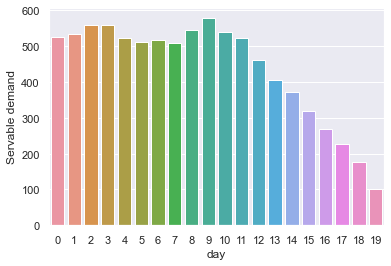

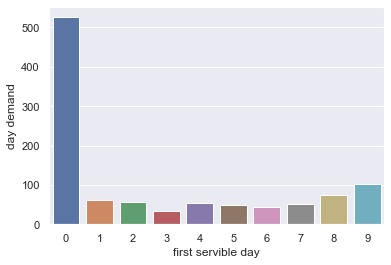

In [182]:
schedule['servableDays'] = schedule.apply(lambda row: list(range(row['begin'],row['end'])), axis =1)
schedule_explode = schedule.explode('servableDays')
schedule_grouped = schedule_explode.groupby('servableDays').sum()
schedule_grouped['day']= schedule_grouped.index
sns.barplot(x='day',y='demand', data=schedule_grouped)
plt.ylabel('Servable demand')
plt.figure()
sns.barplot(x=schedule.groupby('begin').sum().index,y='demand', data=schedule.groupby('begin').sum())
plt.ylabel('day demand')
plt.xlabel('first servible day')

In [184]:
instance.Products

[    1    11]

In [173]:
schedule.groupby('end').sum()

,begin,day,demand,hubLocID,productID
end,,,,,
1,0,2,54,5,0
2,0,2,30,3,0
3,0,6,33,5,0
4,0,8,91,5,0
5,0,10,58,5,0
6,0,12,39,5,0
7,0,14,58,5,0
8,0,16,40,5,0
9,0,18,68,5,0


In [32]:
res

{1: {5: {'routes': {1: {'route': [{'locID': 5,
       'X': 68,
       'Y': 85,
       'demand': 0,
       'collect': 0,
       'service_time': 0,
       'lower': 0,
       'upper': 0,
       'frequency': 1},
      {'locID': 27,
       'reqID': 4,
       'X': 14,
       'Y': 47,
       'demand': 9,
       'amounts': [0, 9, 0],
       'collect': 0,
       'service_time': 0,
       'lower': 0,
       'upper': 0,
       'frequency': 1},
      {'locID': 5,
       'X': 68,
       'Y': 85,
       'demand': 0,
       'collect': 0,
       'service_time': 0,
       'lower': 0,
       'upper': 67,
       'frequency': 1}]}},
   'demand': 9,
   'amounts': [0, 9, 0]},
  9: {'routes': {1: {'route': [{'locID': 9,
       'X': 68,
       'Y': 77,
       'demand': 0,
       'collect': 0,
       'service_time': 0,
       'lower': 0,
       'upper': 0,
       'frequency': 1},
      {'locID': 27,
       'reqID': 6,
       'X': 14,
       'Y': 47,
       'demand': 3,
       'amounts': [0, 2, 1],
       'coll

In [73]:
%%capture
res = solveHub(instance)
G = giantDepotNx(res)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 524.0
INFO:vrpy.master_solve_pulp:total cost = 524.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 464.0
INFO:vrpy.master_solve_pulp:total cost = 464.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 461 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 461 and 1 vehic

In [92]:
class Instance(InstanceCO22):
    def __init__(self, i):
        path = instancePath(i)
        super().__init__(inputfile = path, filetype = 'txt')
        print(self.Locations)

    def getNX(self, dayIDs: list = None, locIDs: list = None,)

In [93]:
Instance(1)

[    1     0     0,     2    18    88,     3    91    27,     4    40    19,     5    44     8,     6     5    84,     7    56    89,     8    99    13,     9    95    14,    10    34    35,    11    17     5,    12    67    73,    13    17    84,    14    39    91,    15    98    74,    16    40    83,    17    80    84,    18    16    80,    19    84    89,    20    82    40,    21    71     2,    22    60    79,    23    61    71]


In [89]:
current = 1
data = G.nodes(data=True)
{i: v for i,v in G.nodes(data=True) if 'periodIDs' in v.keys() and current in v['periodIDs']}

{'d1h5p2': {'X': 68,
  'Y': 85,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 2,
  'hubLocID': 5,
  'demand': 9},
 'd1h9p2': {'X': 68,
  'Y': 77,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 2,
  'hubLocID': 9,
  'demand': 2},
 'd1h9p3': {'X': 68,
  'Y': 77,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 3,
  'hubLocID': 9,
  'demand': 1},
 'd1h14p1': {'X': 40,
  'Y': 27,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 1,
  'hubLocID': 14,
  'demand': 5},
 'd1h14p2': {'X': 40,
  'Y': 27,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 2,
  'hubLocID': 14,
  'demand': 3},
 'd1h18p1': {'X': 86,
  'Y': 92,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 1,
  'hubLocID': 18,
  'demand': 8},
 'd1h18p2': {'X': 86,
  'Y': 92,
  'upper': 1,
  'lower': 0,
  'day': 1,
  'periodIDs': [1],
  'productID': 2,
  'hubLocID': 18,
  'dema

In [143]:
extractDays(res,[1,2,3,4]).keys()

dict_keys([(1, 5), (1, 9), (1, 14), (1, 18), (1, 20), (2, 5), (3, 3), (3, 5), (3, 18), (4, 4), (4, 7), (4, 17), (4, 18), (4, 19)])

In [90]:
def solve(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    depotRoutes = {}
    dmin = min([_.daysFresh for _ in instance.Products])
     
    for i in range(0, math.ceil(nDays/dmin)):  
        periodBegin = dmin*i+1
        periodEnd = dmin*(i+1)+1
        print(i, periodBegin, periodEnd)
        period = list(range(periodBegin, periodEnd))
        periodRoutes = extractDays(hubRoutes, period)
        if len(periodRoutes)>0:                                                #depot routing
            res = solveDepotVRP(instance, periodRoutes)
            depotRoutes[periodBegin] = res
        else:
            depotRoutes[periodBegin] = {}
    return {'hubRoutes': hubRoutes, 'depotRoutes': depotRoutes}

In [144]:
#%%capture
res = solve(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 524.0
INFO:vrpy.master_solve_pulp:total cost = 524.0


[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [4]
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] [6]
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] [5]


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 464.0
INFO:vrpy.master_solve_pulp:total cost = 464.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 461 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 461 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 461.0
INFO:vrpy.vrp:iteration 1, 461.0
INFO:vrpy.vrp:iteration 2, 461.0
INFO:vrpy.master_solve_pulp:total cost = 461.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 460 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 460 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 460.0


[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] [1, 2]
[11, 13, 30, 86] []
[3, 54] [3]


INFO:vrpy.master_solve_pulp:total cost = 460.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 500.0
INFO:vrpy.master_solve_pulp:total cost = 500.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 578.0
INFO:vrpy.master_solve_pulp:total cost = 578.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles


[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [7]
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [8]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [10]


INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 518.0
INFO:vrpy.master_solve_pulp:total cost = 518.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 592.0
INFO:vrpy.master_solve_pulp:total cost = 592.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 574 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 574 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 574.0


[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] [9]
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] [14]
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] [16]


INFO:vrpy.master_solve_pulp:total cost = 574.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 526 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 526 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 526.0
INFO:vrpy.master_solve_pulp:total cost = 526.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 518.0
INFO:vrpy.master_solve_pulp:total cost = 518.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 602.0


[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] [15]
[1, 2, 9, 12, 33, 36] [12]
[11, 13, 30, 86] [11, 13]


INFO:vrpy.master_solve_pulp:total cost = 602.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 502.0
INFO:vrpy.vrp:iteration 1, 502.0
INFO:vrpy.master_solve_pulp:total cost = 502.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 592.0


[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] [20, 21]
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] [18]


INFO:vrpy.master_solve_pulp:total cost = 592.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 554 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 554 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 554.0
INFO:vrpy.master_solve_pulp:total cost = 554.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 484 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 484 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 484.0
INFO:vrpy.master_solve_pulp:total cost = 484.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 498.0


[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] [17]
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] [22]
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [19]


INFO:vrpy.master_solve_pulp:total cost = 498.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 500.0
INFO:vrpy.master_solve_pulp:total cost = 500.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 588 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 588 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 588.0
INFO:vrpy.master_solve_pulp:total cost = 588.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 452.0


[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [24]
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] [25]
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [23]


INFO:vrpy.master_solve_pulp:total cost = 452.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 512.0
INFO:vrpy.master_solve_pulp:total cost = 512.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 604 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 604 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 604.0


[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [28]
[29, 47, 71, 74, 76, 83, 92] [29]
[16, 17, 25, 88, 89] []
[26, 68] [26]


INFO:vrpy.master_solve_pulp:total cost = 604.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 504.0
INFO:vrpy.master_solve_pulp:total cost = 504.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 466 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 466 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 466.0
INFO:vrpy.master_solve_pulp:total cost = 466.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 602.0


[6, 27, 41, 48] [27]
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] [31]
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] [30]


INFO:vrpy.master_solve_pulp:total cost = 602.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 544 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 544 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 544.0
INFO:vrpy.master_solve_pulp:total cost = 544.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 498.0
INFO:vrpy.master_solve_pulp:total cost = 498.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 518.0


[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [32]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] [35]
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] [33]


INFO:vrpy.master_solve_pulp:total cost = 518.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 538.0
INFO:vrpy.master_solve_pulp:total cost = 538.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 452.0


[11, 13, 30, 86] []
[3, 54] []
[34, 91] [34]
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [37]
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [38]


INFO:vrpy.master_solve_pulp:total cost = 452.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 497 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 497 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 497.0
INFO:vrpy.vrp:iteration 1, 497.0
INFO:vrpy.vrp:iteration 2, 497.0
INFO:vrpy.master_solve_pulp:total cost = 497.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 518 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 518.0


[39, 40, 57, 62] [39, 40]
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] [36]


INFO:vrpy.master_solve_pulp:total cost = 518.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 538.0
INFO:vrpy.master_solve_pulp:total cost = 538.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 504.0
INFO:vrpy.master_solve_pulp:total cost = 504.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 546 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 546 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 546.0


[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [43]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] [41]
[35, 42, 51, 73, 75, 80, 84, 87] [42]


INFO:vrpy.master_solve_pulp:total cost = 546.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 571 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 571 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 571.0
INFO:vrpy.vrp:iteration 1, 571.0
INFO:vrpy.vrp:iteration 2, 571.0
INFO:vrpy.master_solve_pulp:total cost = 571.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 538.0


[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [44, 46]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [45, 53]


INFO:vrpy.vrp:iteration 1, 538.0
INFO:vrpy.vrp:iteration 2, 538.0
INFO:vrpy.master_solve_pulp:total cost = 538.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 568 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 568 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 568.0
INFO:vrpy.master_solve_pulp:total cost = 568.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 524.0
INFO:vrpy.master_solve_pulp:total cost = 524.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 604 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 604 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 604.0


[29, 47, 71, 74, 76, 83, 92] [47]
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] [48]
[35, 42, 51, 73, 75, 80, 84, 87] [51]


INFO:vrpy.master_solve_pulp:total cost = 604.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 484 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 484 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 484.0
INFO:vrpy.master_solve_pulp:total cost = 484.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 546 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 546 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 546.0
INFO:vrpy.master_solve_pulp:total cost = 546.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 452 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 452.0


[22, 31, 50, 77] [50]
[] []
[49] [49]
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [52]


INFO:vrpy.master_solve_pulp:total cost = 452.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 492 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 492 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 492.0
INFO:vrpy.master_solve_pulp:total cost = 492.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 432 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 432 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 432.0
INFO:vrpy.master_solve_pulp:total cost = 432.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] [54]
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [56]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [58]


INFO:vrpy.vrp:Clarke & Wright solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 500 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 500.0
INFO:vrpy.master_solve_pulp:total cost = 500.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 460 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 460 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 460.0
INFO:vrpy.master_solve_pulp:total cost = 460.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 488 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 488 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 488.0
INFO:vrpy.master_solve_pulp:total cost = 488.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 502.0


[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] [57]
[15, 55, 85, 95, 99] [55]
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] [63, 64]


INFO:vrpy.master_solve_pulp:total cost = 502.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 560 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 560 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 560.0
INFO:vrpy.master_solve_pulp:total cost = 560.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 513 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 513 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 513.0
INFO:vrpy.vrp:iteration 1, 513.0
INFO:vrpy.vrp:iteration 2, 513.0


[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [60, 65]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] [59, 61]


INFO:vrpy.master_solve_pulp:total cost = 513.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 436 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 436 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 436.0
INFO:vrpy.master_solve_pulp:total cost = 436.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 578.0
INFO:vrpy.master_solve_pulp:total cost = 578.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0


[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] [62]
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [67]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [66, 69]


INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 510 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 510 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 510.0
INFO:vrpy.master_solve_pulp:total cost = 510.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 454 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 454 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 454.0
INFO:vrpy.master_solve_pulp:total cost = 454.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 626 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 626 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 626.0


[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] [68]
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] [70]
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] [71, 74]


INFO:vrpy.vrp:iteration 1, 626.0
INFO:vrpy.vrp:iteration 2, 626.0
INFO:vrpy.master_solve_pulp:total cost = 626.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 547 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 547 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 547.0
INFO:vrpy.vrp:iteration 1, 547.0
INFO:vrpy.vrp:iteration 2, 547.0
INFO:vrpy.master_solve_pulp:total cost = 547.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 474 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 474 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 474.0


[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] [73, 75]
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [72]


INFO:vrpy.master_solve_pulp:total cost = 474.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 510 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 510 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 510.0
INFO:vrpy.master_solve_pulp:total cost = 510.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 614 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 614 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 614.0
INFO:vrpy.master_solve_pulp:total cost = 614.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 498 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 498.0


[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] [79]
[29, 47, 71, 74, 76, 83, 92] [76]
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] [80]


INFO:vrpy.master_solve_pulp:total cost = 498.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 554 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 554 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 554.0
INFO:vrpy.master_solve_pulp:total cost = 554.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 474 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 474 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 474.0
INFO:vrpy.master_solve_pulp:total cost = 474.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 560 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 560 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 560.0


[22, 31, 50, 77] [77]
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [78]
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [81]


INFO:vrpy.master_solve_pulp:total cost = 560.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 512.0
INFO:vrpy.master_solve_pulp:total cost = 512.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 574 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 574 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 574.0
INFO:vrpy.master_solve_pulp:total cost = 574.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 606 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 606 and 1 vehicles


[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] [83]
[16, 17, 25, 88, 89] [88]
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] [84, 87]


INFO:vrpy.vrp:iteration 0, 606.0
INFO:vrpy.vrp:iteration 1, 606.0
INFO:vrpy.vrp:iteration 2, 606.0
INFO:vrpy.master_solve_pulp:total cost = 606.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 408 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 408 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 408.0
INFO:vrpy.master_solve_pulp:total cost = 408.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 526 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 526 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 526.0
INFO:vrpy.master_solve_pulp:total cost = 526.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 602 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 602.0


[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [82]
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] [85]
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] [86]


INFO:vrpy.master_solve_pulp:total cost = 602.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 578 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 578.0
INFO:vrpy.master_solve_pulp:total cost = 578.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 580 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 580 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 580.0
INFO:vrpy.master_solve_pulp:total cost = 580.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 592 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 592.0


[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] [89]
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] []
[19, 23, 38, 52, 72, 78, 82, 90, 97] [90]
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
[20, 21, 63, 64, 70, 96] []
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] []
[14, 18, 94] [94]


INFO:vrpy.master_solve_pulp:total cost = 592.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 614 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 614 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 614.0
INFO:vrpy.master_solve_pulp:total cost = 614.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 512.0
INFO:vrpy.master_solve_pulp:total cost = 512.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 504 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 504.0


[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] [92]
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] [93]
[19, 23, 38, 52, 72, 78, 82, 90, 97] []
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] []
[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] [91]


INFO:vrpy.master_solve_pulp:total cost = 504.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 502 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 502.0
INFO:vrpy.master_solve_pulp:total cost = 502.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 538 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 538.0
INFO:vrpy.master_solve_pulp:total cost = 538.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 512 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 512.0


[20, 21, 63, 64, 70, 96] [96]
[8, 32, 43, 44, 46, 56, 60, 65, 67, 81, 100] [100]
[14, 18, 94] []
[4, 7, 10, 24, 28, 37, 45, 53, 58, 66, 69, 79] []
[29, 47, 71, 74, 76, 83, 92] []
[16, 17, 25, 88, 89] []
[26, 68] []
[6, 27, 41, 48] []
[35, 42, 51, 73, 75, 80, 84, 87] []
[22, 31, 50, 77] []
[] []
[49] []
[5, 59, 61, 93, 98] [98]


INFO:vrpy.master_solve_pulp:total cost = 512.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 522 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 522 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 522.0
INFO:vrpy.master_solve_pulp:total cost = 522.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 542 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 542 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 542.0
INFO:vrpy.vrp:iteration 1, 542.0
INFO:vrpy.vrp:iteration 2, 542.0


[19, 23, 38, 52, 72, 78, 82, 90, 97] [97]
[39, 40, 57, 62] []
[15, 55, 85, 95, 99] [95, 99]


INFO:vrpy.master_solve_pulp:total cost = 542.0
INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 2320 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2299 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2299.0
INFO:vrpy.vrp:iteration 1, 2299.0


[1, 2, 9, 12, 33, 36] []
[11, 13, 30, 86] []
[3, 54] []
[34, 91] []
0 1 5
dict_keys(['5.1', '9.1', '14.1', '18.1', '20.1', '3.1', '4.1', '7.1', '17.1', '19.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 2, 2299.0
INFO:vrpy.vrp:iteration 3, 2299.0
INFO:vrpy.vrp:iteration 4, 2299.0
INFO:vrpy.vrp:iteration 5, 2299.0
INFO:vrpy.vrp:iteration 6, 2299.0
INFO:vrpy.vrp:iteration 7, 2299.0
INFO:vrpy.vrp:iteration 8, 2299.0
INFO:vrpy.vrp:iteration 9, 2299.0
INFO:vrpy.vrp:iteration 10, 2299.0
INFO:vrpy.vrp:iteration 11, 2299.0
INFO:vrpy.vrp:iteration 12, 2299.0
INFO:vrpy.vrp:iteration 13, 2299.0
INFO:vrpy.vrp:iteration 14, 2299.0
INFO:vrpy.vrp:iteration 15, 2299.0
INFO:vrpy.vrp:iteration 16, 2299.0
INFO:vrpy.vrp:iteration 17, 2299.0
INFO:vrpy.vrp:iteration 18, 2299.0
INFO:vrpy.vrp:iteration 19, 2299.0
INFO:vrpy.vrp:iteration 20, 2299.0
INFO:vrpy.vrp:iteration 21, 2299.0
INFO:vrpy.vrp:iteration 22, 2299.0
INFO:vrpy.vrp:iteration 23, 2299.0
INFO:vrpy.vrp:iteration 24, 2299.0
INFO:vrpy.vrp:iteration 25, 2299.0
INFO:vrpy.vrp:iteration 26, 2299.0
INFO:vrpy.vrp:iteration 27, 2299.0
INFO:vrpy.vrp:iteration 28, 2299.0
INFO:vrpy.vrp:iteration 29, 2299.0
INFO:vrpy.vrp:iteration 30, 

{1: ['Source', '20.1', '7.1', '9.1', '5.1', '3.1', '18.1', '19.1', '4.1', '14.1', '17.1', 'Sink']}
{1: [{'locID': 1, 'X': 40, 'Y': 3, 'demand': 0, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 20, 'demand': 16, 'amounts': [0, 9, 7], 'X': 21, 'Y': 21, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 7, 'demand': 11, 'amounts': [0, 7, 4], 'X': 3, 'Y': 32, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 9, 'demand': 3, 'amounts': [0, 2, 1], 'X': 7, 'Y': 36, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 5, 'demand': 25, 'amounts': [5, 16, 4], 'X': 4, 'Y': 52, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 3, 'demand': 11, 'amounts': [5, 0, 6], 'X': 13, 'Y': 60, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 18, 'demand': 37, 'amounts': [8, 11, 18], 'X': 27, 'Y': 65, 'colle

INFO:vrpy.vrp:iteration 1, 2354.0
INFO:vrpy.vrp:iteration 2, 2354.0
INFO:vrpy.vrp:iteration 3, 2354.0
INFO:vrpy.vrp:iteration 4, 2354.0
INFO:vrpy.vrp:iteration 5, 2354.0
INFO:vrpy.vrp:iteration 6, 2354.0
INFO:vrpy.vrp:iteration 7, 2354.0
INFO:vrpy.vrp:iteration 8, 2354.0
INFO:vrpy.vrp:iteration 9, 2354.0
INFO:vrpy.vrp:iteration 10, 2354.0
INFO:vrpy.vrp:iteration 11, 2354.0
INFO:vrpy.vrp:iteration 12, 2354.0
INFO:vrpy.vrp:iteration 13, 2354.0
INFO:vrpy.vrp:iteration 14, 2354.0
INFO:vrpy.vrp:iteration 15, 2354.0
INFO:vrpy.vrp:iteration 16, 2354.0
INFO:vrpy.vrp:iteration 17, 2354.0
INFO:vrpy.vrp:iteration 18, 2354.0
INFO:vrpy.vrp:iteration 19, 2354.0
INFO:vrpy.vrp:iteration 20, 2354.0
INFO:vrpy.vrp:iteration 21, 2354.0
INFO:vrpy.vrp:iteration 22, 2354.0
INFO:vrpy.vrp:iteration 23, 2354.0
INFO:vrpy.vrp:iteration 24, 2354.0
INFO:vrpy.vrp:iteration 25, 2354.0
INFO:vrpy.vrp:iteration 26, 2354.0
INFO:vrpy.vrp:iteration 27, 2354.0
INFO:vrpy.vrp:iteration 28, 2354.0
INFO:vrpy.vrp:iteration 29, 2

{1: ['Source', '11.1', '15.1', '2.1', '9.1', '7.1', '21.1', '5.1', '3.1', '18.1', '10.1', '6.1', '19.1', '4.1', '8.1', 'Sink']}
{1: [{'locID': 1, 'X': 40, 'Y': 3, 'demand': 0, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 11, 'demand': 19, 'amounts': [11, 8, 0], 'X': 41, 'Y': 5, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 15, 'demand': 17, 'amounts': [14, 0, 3], 'X': 40, 'Y': 27, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 2, 'demand': 26, 'amounts': [9, 10, 7], 'X': 30, 'Y': 32, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 9, 'demand': 13, 'amounts': [0, 7, 6], 'X': 7, 'Y': 36, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 7, 'demand': 16, 'amounts': [8, 5, 3], 'X': 3, 'Y': 32, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 21, 'demand': 8, 'amounts': [6, 2

INFO:vrpy.vrp:iteration 2, 2267.0
INFO:vrpy.vrp:iteration 3, 2267.0
INFO:vrpy.vrp:iteration 4, 2267.0
INFO:vrpy.vrp:iteration 5, 2267.0
INFO:vrpy.vrp:iteration 6, 2267.0
INFO:vrpy.vrp:iteration 7, 2267.0
INFO:vrpy.vrp:iteration 8, 2267.0
INFO:vrpy.vrp:iteration 9, 2267.0
INFO:vrpy.vrp:iteration 10, 2267.0
INFO:vrpy.vrp:iteration 11, 2267.0
INFO:vrpy.vrp:iteration 12, 2267.0
INFO:vrpy.vrp:iteration 13, 2267.0
INFO:vrpy.vrp:iteration 14, 2267.0
INFO:vrpy.vrp:iteration 15, 2267.0
INFO:vrpy.vrp:iteration 16, 2267.0
INFO:vrpy.vrp:iteration 17, 2267.0
INFO:vrpy.vrp:iteration 18, 2267.0
INFO:vrpy.vrp:iteration 19, 2267.0
INFO:vrpy.vrp:iteration 20, 2267.0
INFO:vrpy.vrp:iteration 21, 2267.0
INFO:vrpy.vrp:iteration 22, 2267.0
INFO:vrpy.vrp:iteration 23, 2267.0
INFO:vrpy.vrp:iteration 24, 2267.0
INFO:vrpy.vrp:iteration 25, 2267.0
INFO:vrpy.vrp:iteration 26, 2267.0
INFO:vrpy.vrp:iteration 27, 2267.0
INFO:vrpy.vrp:iteration 28, 2267.0
INFO:vrpy.vrp:iteration 29, 2267.0
INFO:vrpy.vrp:iteration 30, 

{1: ['Source', '11.1', '13.1', '16.1', '15.1', '10.1', '6.1', '18.1', '3.1', '5.1', '9.1', '20.1', '17.1', 'Sink']}
{1: [{'locID': 1, 'X': 40, 'Y': 3, 'demand': 0, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 11, 'demand': 8, 'amounts': [0, 6, 2], 'X': 41, 'Y': 5, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 13, 'demand': 8, 'amounts': [0, 8, 0], 'X': 59, 'Y': 1, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 16, 'demand': 23, 'amounts': [9, 12, 2], 'X': 54, 'Y': 13, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 15, 'demand': 15, 'amounts': [0, 9, 6], 'X': 40, 'Y': 27, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 10, 'demand': 8, 'amounts': [3, 2, 3], 'X': 68, 'Y': 77, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 6, 'demand': 1, 'amounts': [1, 0, 0], 'X': 68,

INFO:vrpy.vrp:iteration 2, 2312.0
INFO:vrpy.vrp:iteration 3, 2312.0
INFO:vrpy.vrp:iteration 4, 2312.0
INFO:vrpy.vrp:iteration 5, 2312.0
INFO:vrpy.vrp:iteration 6, 2312.0
INFO:vrpy.vrp:iteration 7, 2312.0
INFO:vrpy.vrp:iteration 8, 2312.0
INFO:vrpy.vrp:iteration 9, 2312.0
INFO:vrpy.vrp:iteration 10, 2312.0
INFO:vrpy.vrp:iteration 11, 2312.0
INFO:vrpy.vrp:iteration 12, 2312.0
INFO:vrpy.vrp:iteration 13, 2312.0
INFO:vrpy.vrp:iteration 14, 2312.0
INFO:vrpy.vrp:iteration 15, 2312.0
INFO:vrpy.vrp:iteration 16, 2312.0
INFO:vrpy.vrp:iteration 17, 2312.0
INFO:vrpy.vrp:iteration 18, 2312.0
INFO:vrpy.vrp:iteration 19, 2291.0
INFO:vrpy.vrp:iteration 20, 2291.0
INFO:vrpy.vrp:iteration 21, 2291.0
INFO:vrpy.master_solve_pulp:total cost = 2291.0
INFO:vrpy.vrp:new upper bound : max num stops = 13
INFO:vrpy.vrp:Clarke & Wright solution found with value 2302 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2321 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2302.0
INFO:vrpy.vrp:iteration 1, 2302.

{1: ['Source', '16.1', '8.1', '14.1', '6.1', '10.1', '3.1', '5.1', '2.1', '15.1', '11.1', 'Sink']}
{1: [{'locID': 1, 'X': 40, 'Y': 3, 'demand': 0, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 16, 'demand': 14, 'amounts': [6, 0, 8], 'X': 54, 'Y': 13, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 8, 'demand': 11, 'amounts': [6, 0, 5], 'X': 95, 'Y': 17, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 14, 'demand': 26, 'amounts': [15, 11, 0], 'X': 86, 'Y': 76, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 6, 'demand': 34, 'amounts': [11, 15, 8], 'X': 68, 'Y': 85, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 10, 'demand': 16, 'amounts': [1, 14, 1], 'X': 68, 'Y': 77, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 3, 'demand': 24, 'amounts': [16, 0, 8], 'X': 13, 'Y': 60

INFO:vrpy.vrp:iteration 2, 2302.0
INFO:vrpy.vrp:iteration 3, 2302.0
INFO:vrpy.vrp:iteration 4, 2302.0
INFO:vrpy.vrp:iteration 5, 2302.0
INFO:vrpy.vrp:iteration 6, 2302.0
INFO:vrpy.vrp:iteration 7, 2302.0
INFO:vrpy.vrp:iteration 8, 2302.0
INFO:vrpy.vrp:iteration 9, 2302.0
INFO:vrpy.vrp:iteration 10, 2302.0
INFO:vrpy.vrp:iteration 11, 2302.0
INFO:vrpy.vrp:iteration 12, 2302.0
INFO:vrpy.vrp:iteration 13, 2302.0
INFO:vrpy.vrp:iteration 14, 2302.0
INFO:vrpy.vrp:iteration 15, 2302.0
INFO:vrpy.vrp:iteration 16, 2302.0
INFO:vrpy.vrp:iteration 17, 2302.0
INFO:vrpy.vrp:iteration 18, 2302.0
INFO:vrpy.vrp:iteration 19, 2302.0
INFO:vrpy.vrp:iteration 20, 2302.0
INFO:vrpy.vrp:iteration 21, 2302.0
INFO:vrpy.vrp:iteration 22, 2302.0
INFO:vrpy.vrp:iteration 23, 2302.0
INFO:vrpy.vrp:iteration 24, 2302.0
INFO:vrpy.vrp:iteration 25, 2302.0
INFO:vrpy.vrp:iteration 26, 2302.0
INFO:vrpy.vrp:iteration 27, 2302.0
INFO:vrpy.vrp:iteration 28, 2302.0
INFO:vrpy.vrp:iteration 29, 2302.0
INFO:vrpy.vrp:iteration 30, 

{1: ['Source', '21.1', '7.1', '3.1', '10.1', '6.1', '19.1', '4.1', '14.1', '2.1', '15.1', '17.1', 'Sink']}
{1: [{'locID': 1, 'X': 40, 'Y': 3, 'demand': 0, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 21, 'demand': 8, 'amounts': [0, 1, 7], 'X': 8, 'Y': 18, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 7, 'demand': 24, 'amounts': [7, 3, 14], 'X': 3, 'Y': 32, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 3, 'demand': 20, 'amounts': [13, 7, 0], 'X': 13, 'Y': 60, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 10, 'demand': 15, 'amounts': [0, 11, 4], 'X': 68, 'Y': 77, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 6, 'demand': 10, 'amounts': [3, 1, 6], 'X': 68, 'Y': 85, 'collect': 0, 'service_time': 0, 'lower': 0, 'upper': 0, 'frequency': 1}, {'locID': 19, 'demand': 2, 'amounts': [0, 2, 0], 'X': 86, 'Y': 9

In [76]:
print(pprint.pformat(res))

{'depotRoutes': {1: {1: [{'X': 40,
                          'Y': 3,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 40,
                          'Y': 27,
                          'amounts': [5, 3, 0],
                          'collect': 0,
                          'demand': 8,
                          'frequency': 1,
                          'locID': 14,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 21,
                          'Y': 21,
                          'amounts': [0, 1, 6],
                          'collect': 0,
                          'demand': 7,
                          'frequency': 1,
           

In [146]:
def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"

        truckString = ""
        if day in res['depotRoutes'].keys():
            nTrucks = len(res['depotRoutes'][day])
            for routeID, truckRoute in res['depotRoutes'][day].items():
                truckString += f"{routeID} "
                for i, hubData in enumerate(truckRoute[1:-1]):
                    amountPerProduct = hubData['amounts']
                    truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
                truckString += "\n"
        else:
            nTrucks = 0
            
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i+=1
                reqIds = [_['reqID'] for _ in route['route'][1:-1] ]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    

In [147]:
solutionToStr(instance,res)

'DATASET = CO2022_11 \n \nDAY = 1 \nNUMBER_OF_TRUCKS = 1 \n1 H19 0,9,7 H6 0,7,4 H8 0,2,1 H4 5,16,4 H2 5,0,6 H17 8,11,18 H18 0,1,6 H3 6,7,0 H13 5,3,0 H16 0,0,8 \nNUMBER_OF_VANS = 5 \n1 H4 4 \n2 H8 6 \n3 H13 5 \n4 H17 1 2 \n5 H19 3 \n\nDAY = 2 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 1 \n1 H4 7 \n\nDAY = 3 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H2 8 \n2 H4 10 \n3 H17 9 \n\nDAY = 4 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 5 \n1 H3 14 \n2 H6 16 \n3 H16 15 \n4 H17 12 \n5 H18 11 13 \n\nDAY = 5 \nNUMBER_OF_TRUCKS = 1 \n1 H10 11,8,0 H14 14,0,3 H1 9,10,7 H8 0,7,6 H6 8,5,3 H20 6,2,0 H4 0,10,10 H2 7,0,4 H17 0,3,7 H9 6,3,0 H5 1,0,1 H18 3,0,2 H3 0,1,0 H7 1,0,2 \nNUMBER_OF_VANS = 5 \n1 H1 20 21 \n2 H3 18 \n3 H6 17 \n4 H10 22 \n5 H14 19 \n\nDAY = 6 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H4 24 \n2 H6 25 \n3 H14 23 \n\nDAY = 7 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 6 \n1 H4 28 \n2 H5 29 \n3 H7 26 \n4 H8 27 \n5 H10 31 \n6 H18 30 \n\nDAY = 8 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS 

In [148]:
solutionStr = solutionToStr(instance,res)
with open("./solution_test_greedy2.txt" ,'w') as file:
    file.write(solutionStr)


In [ ]:
#assign hub to locations
#for each day, for each hub:
    #get request for hub, day
    #turn into networkX graph
    #solve using vrpy
    #store results
